In [1]:
cd ..

/Users/janperina/projects/masters-thesis


In [2]:
import glob
import pandas as pd
import numpy as np
import json
import os

In [3]:
data = []
for file in sorted(glob.glob("data/pic-CSCS_LCG2/*json")):
    with open(file) as f:
        data.append(json.load(f))

In [4]:
from traced_v2.models.bernoulli import BernoulliModel

In [5]:
field = "path_complete"

In [6]:
site_to_site_model = BernoulliModel(src="CA-SFU-T2", dest="CSCS-LCG2", scorer=lambda x, y: False)

In [7]:
for sample in data:
    site_to_site_model.log(sample['timestamp'], sample.get(field, False))

In [8]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Probability of ipv6 communication from CA-SFU-T2 to CSCS-LCG2')

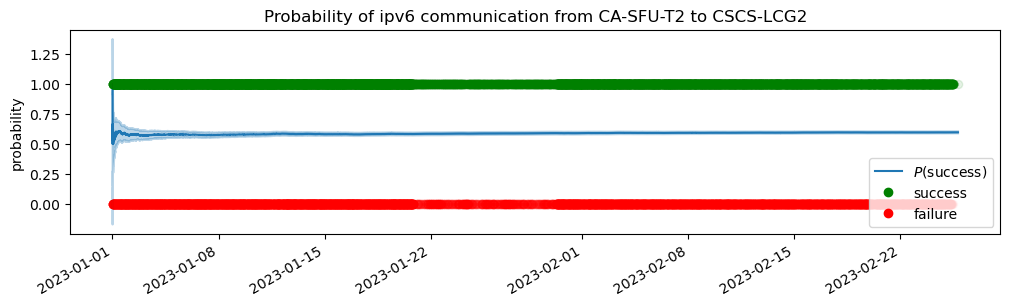

In [9]:
fig = plt.figure(figsize=(12, 3))
site_to_site_model.plot(ax=fig.gca())

plt.title("Probability of ipv6 communication from CA-SFU-T2 to CSCS-LCG2")

In [10]:
fig.savefig("results/figures/bernouli_s2s_ip.png", dpi=300, bbox_inches='tight')

In [11]:
any(site_to_site_model.anomalies)

False

In [12]:
from collections import defaultdict

In [13]:
device_to_device = defaultdict(lambda:{})


In [14]:
for sample in data:
    if sample['dest'] not in device_to_device[sample['src']]:
        device_to_device[sample['src']][sample['dest']] = BernoulliModel(
            src=sample['src'], dest=sample['dest'], 
            # scorer=lambda x, y: False
            scorer=lambda x, p: x if p < 0.2 else not x if p > 0.68 else False
            )
    device_to_device[sample['src']][sample['dest']] .log(sample['timestamp'], sample.get(field, False))

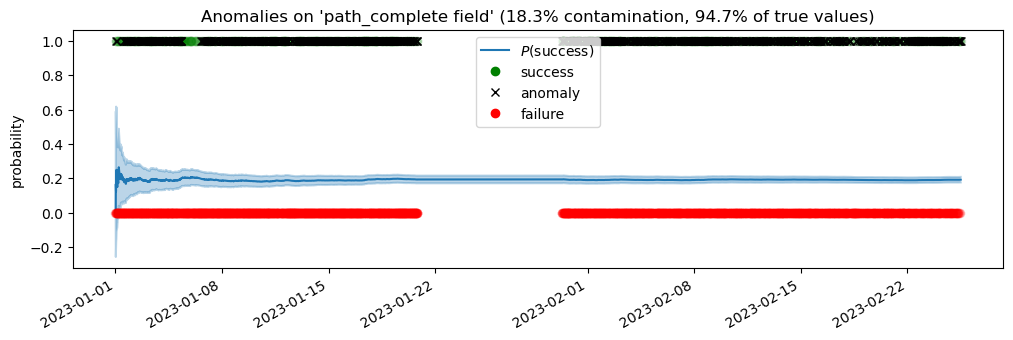

In [15]:
fig = plt.figure(figsize=(12, 3.5))
device_to_device['2001:67c:1148:204::250']['2001:620:808:4129::15'].plot(ax=fig.gca())
c=device_to_device['2001:67c:1148:204::250']['2001:620:808:4129::15']
plt.title(f"Anomalies on 'path_complete field' ({round(100*sum(c.anomalies)/c.n, 1)}% contamination, {round(100*sum(c.anomalies)/sum(c.observed_variables), 1)}% of true values)")
fig.savefig("results/figures/bernouli_dr_anom.png", dpi=300, bbox_inches='tight')

<bound method Figure.savefig of <Figure size 1200x500 with 1 Axes>>

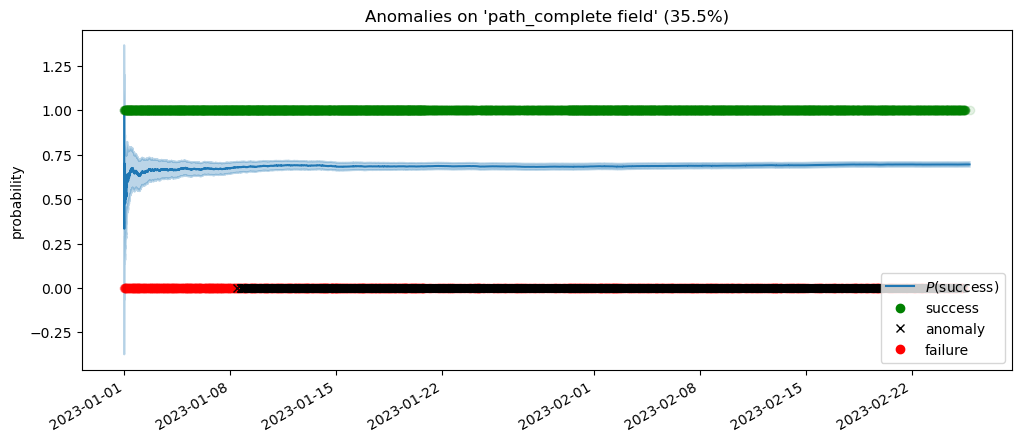

In [16]:
fig = plt.figure(figsize=(12, 5))
device_to_device['193.109.172.242']['148.187.129.15'].plot(ax=fig.gca())
c=device_to_device['193.109.172.242']['148.187.129.15']
plt.title(f"Anomalies on 'path_complete field' ({round(100*sum(c.anomalies)/sum(c.observed_variables), 1)}%)")
fig.savefig

In [17]:
device_to_device

defaultdict(<function __main__.<lambda>()>,
            {'193.109.172.250': {'148.187.129.15': <traced_v2.models.bernoulli.BernoulliModel at 0x17d173100>},
             '193.109.172.242': {'148.187.129.15': <traced_v2.models.bernoulli.BernoulliModel at 0x17d173280>},
             '2001:67c:1148:204::250': {'2001:620:808:4129::15': <traced_v2.models.bernoulli.BernoulliModel at 0x17d173040>}})

In [18]:
import matplotlib.pyplot as plt

In [19]:
df = site_to_site_model.to_frame()

In [20]:
df.columns

Index(['success_probs', 'success_var', 'observed_variables', 'anomalies'], dtype='object')

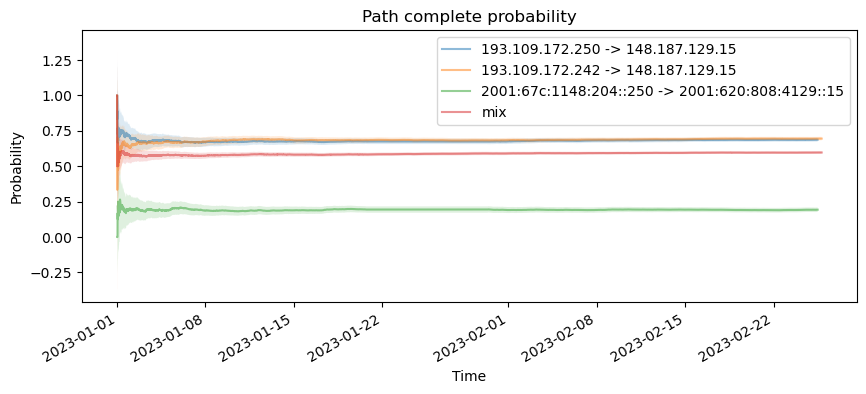

In [21]:
fig, ax = plt.subplots(figsize=(10, 4))


df = device_to_device['193.109.172.250']['148.187.129.15'].to_frame()
df.plot(y='success_probs', label='193.109.172.250 -> 148.187.129.15', ax=ax, alpha=0.5)
ax.fill_between(x=df.index, y1=-3*df['success_var'].apply(np.sqrt) + df['success_probs'], y2=3*df['success_var'].apply(np.sqrt)+df['success_probs'],  alpha=0.15)


df = device_to_device['193.109.172.242']['148.187.129.15'].to_frame()
df.plot(y='success_probs', label='193.109.172.242 -> 148.187.129.15', ax=ax, alpha=0.5)
ax.fill_between(x=df.index, y1=-3*df['success_var'].apply(np.sqrt) + df['success_probs'], y2=3*df['success_var'].apply(np.sqrt)+df['success_probs'], alpha=0.15 )

df = device_to_device['2001:67c:1148:204::250']['2001:620:808:4129::15'].to_frame()
df.plot(y='success_probs', label='2001:67c:1148:204::250 -> 2001:620:808:4129::15', ax=ax, alpha=0.5)
ax.fill_between(x=df.index, y1=-3*df['success_var'].apply(np.sqrt) + df['success_probs'], y2=3*df['success_var'].apply(np.sqrt)+df['success_probs'],  alpha=0.15)


df = site_to_site_model.to_frame()
df.plot(y='success_probs', label='mix', ax=ax, alpha=0.5)
ax.fill_between(x=df.index, y1=-3*df['success_var'].apply(np.sqrt) + df['success_probs'], y2=3*df['success_var'].apply(np.sqrt)+df['success_probs'], alpha=0.15 )



plt.xlabel('Time')
plt.ylabel("Probability")
plt.title("Path complete probability")

fig.savefig("results/figures/path_complete_probs.png", dpi=300, bbox_inches='tight')

In [22]:
counts = defaultdict(lambda: defaultdict(lambda: 0))

In [23]:
for sample in data:
    counts[sample['src']][sample['dest']] += 1


In [24]:
counts

defaultdict(<function __main__.<lambda>()>,
            {'193.109.172.250': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'148.187.129.15': 10839}),
             '193.109.172.242': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'148.187.129.15': 12435}),
             '2001:67c:1148:204::250': defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {'2001:620:808:4129::15': 5441})})

In [25]:
df = pd.DataFrame(counts).fillna(0)
df


,193.109.172.250,193.109.172.242,2001:67c:1148:204::250
148.187.129.15,10839.0,12435.0,0.0
2001:620:808:4129::15,0.0,0.0,5441.0


In [26]:
df.sum().sum()

28715.0

In [27]:
import seaborn as sns   

In [28]:
df_normalized = df/df.sum().sum()

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, '193.109.172.250'),
  Text(1.5, 0, '193.109.172.242'),
  Text(2.5, 0, '2001:67c:1148:204::250')])

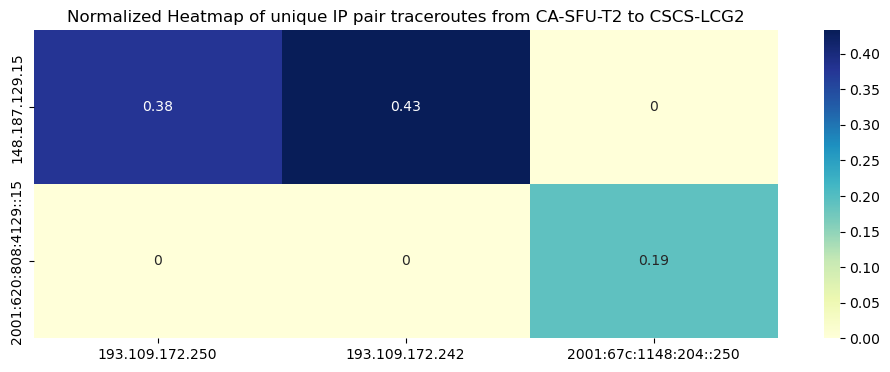

In [29]:
fig = plt.figure(figsize=(12, 4))
sns.heatmap(df_normalized, annot=True, cmap="YlGnBu")

# Optional: Customize the heatmap here (e.g., setting a title).
plt.title('Normalized Heatmap of unique IP pair traceroutes from CA-SFU-T2 to CSCS-LCG2')

fig.savefig("results/figures/heatmap_ip_counts.png", dpi=300, bbox_inches='tight')
# rotate x label
plt.xticks(rotation=0)
# Display the heatmap.


In [30]:
from traced_v2.models.poisson import PoissonModel

In [31]:
n_hops = defaultdict(lambda: {})
for trace in data:
    if trace['dest'] not in n_hops[trace['src']]:
        n_hops[trace['src']][trace['dest']] = PoissonModel(src=trace['src'], dest=trace['dest'], threshold=0.1)
    n_hops[trace['src']][trace['dest']].log(trace['timestamp'], (trace['n_hops']))

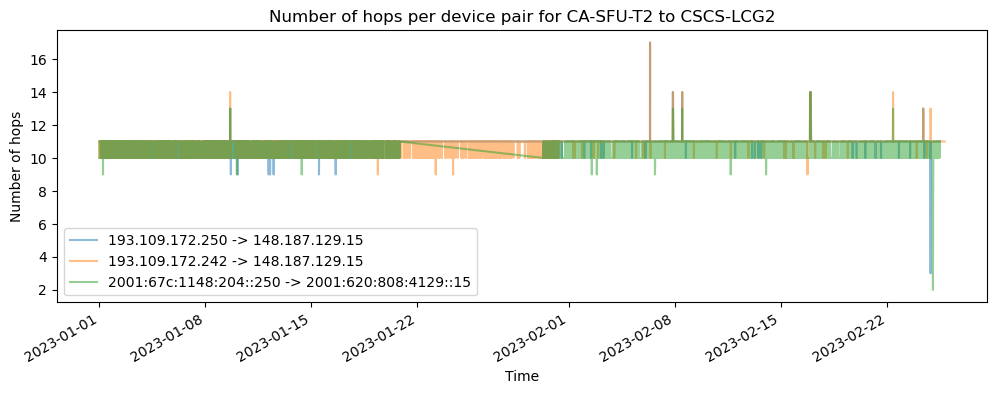

In [32]:
fig = plt.figure(figsize=(12, 4))

for src in n_hops:
    for dest in n_hops[src]:
        n_hops[src][dest].to_frame().plot(y='observed_values', label=f'{src} -> {dest}', ax=fig.gca(), alpha=0.5)
plt.ylabel("Number of hops")
plt.xlabel("Time")
plt.title("Number of hops per device pair for CA-SFU-T2 to CSCS-LCG2")
plt.savefig("results/figures/n_hops_device-to-device.png", dpi=300, bbox_inches='tight')

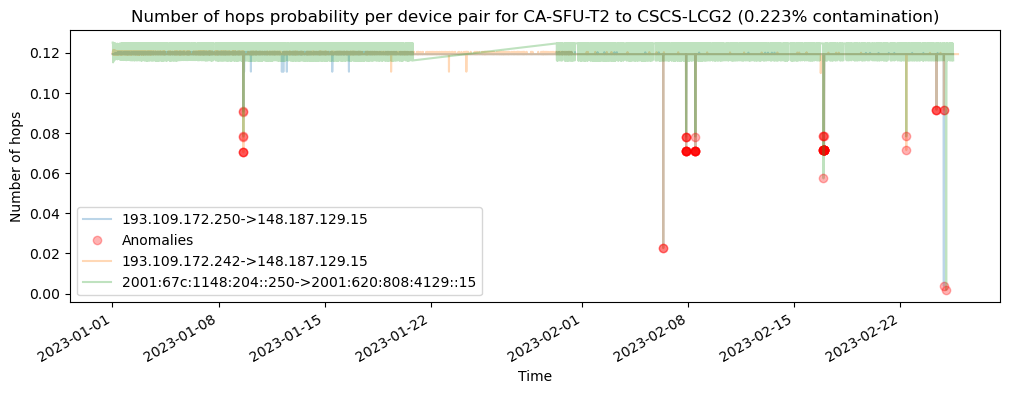

In [33]:
fig = plt.figure(figsize=(12, 4))
probs=[]

first = True
anom_label = "Anomalies"
total_anomalies = 0
for src in n_hops:
    for dest in n_hops[src]:
        # n_hops[src][dest].anomalies = [False] * (n_hops[src][dest].n+1)
        
        n_hops[src][dest].plot( ax=fig.gca(), label=f'{src}->{dest}', alpha=0.3, anom_label=anom_label)
        if first:
            anom_label = ""
        probs.extend(n_hops[src][dest].probs)
        total_anomalies += sum(n_hops[src][dest].anomalies)
plt.ylabel("Number of hops")
plt.xlabel("Time")
plt.title(f"Number of hops probability per device pair for CA-SFU-T2 to CSCS-LCG2 ({100 * total_anomalies / len(probs):.3f}% contamination)")
plt.savefig("results/figures/n_hops_device-to-device_probs_anom_autoupdate.png", dpi=300, bbox_inches='tight')

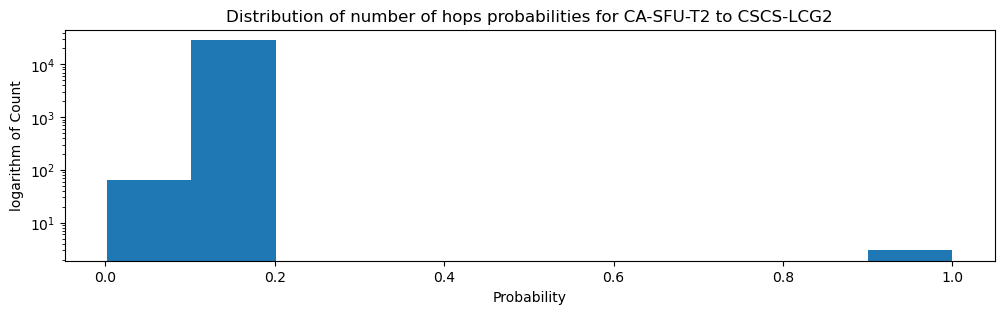

In [34]:
fig = plt.figure(figsize=(12, 3));
plt.hist(probs, log=True);
plt.title("Distribution of number of hops probabilities for CA-SFU-T2 to CSCS-LCG2");
plt.xlabel("Probability");  
plt.ylabel("logarithm of Count");
plt.savefig("results/figures/n_hops_device-to-device_probs_hist.png", dpi=300, bbox_inches='tight')

In [35]:
from scipy.stats import poisson, gamma, beta

In [36]:
import numpy as np

In [37]:
X = np.arange(0, 32, 1)

In [38]:
lambdas = np.round(np.logspace(0, 1.3, 5), 2)


In [39]:
lambdas = np.hstack([[0.5], lambdas])

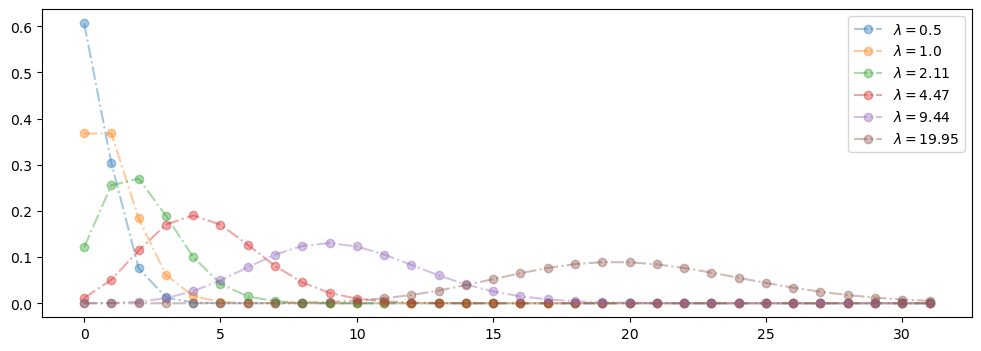

In [40]:
fig = plt.figure(figsize=(12, 4))
for l in lambdas:
    pmfs = poisson.pmf(X, l)
    plt.plot(X, pmfs, label=f'$\lambda={l}$', linestyle='-.', marker="o", alpha=0.4)

plt.legend()
plt.savefig("results/figures/poisson_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

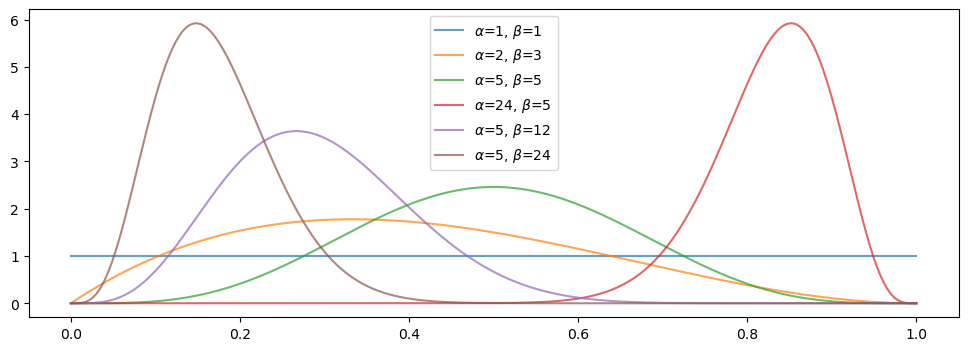

In [41]:
alphas = [1, 2, 5, 24, 5, 5]
betas = [1, 3,5, 5, 12, 24 ]
X = np.linspace(0, 1, 1000)
fig = plt.figure(figsize=(12, 4))
for a,b in zip(alphas, betas):
    pmfs = beta.pdf(X, a, b)
    plt.plot(X, pmfs, label=f'$\\alpha$={a}, $\\beta$={b}', alpha=0.7)

plt.legend()
plt.savefig("results/figures/beta_distributions.png", dpi=300, bbox_inches='tight')
# plt.show()

In [42]:
from traced_v2.models.normal import NormalModel

In [43]:
rtt = []
sum_rtt= []
log_rtt = []
sum_log_rtt = []

for trace in data:
    if trace['src'] in ['193.109.172.250','193.109.172.242', ]:
        continue
    rtt.extend(trace['rtts'])
    sum_rtt.append(sum(trace['rtts']))
    log_rtt.extend(np.sqrt([x for x in trace['rtts'] if x > 0]))
    sum_log_rtt.append(sum(np.sqrt([x for x in trace['rtts'] if x > 0])))
   

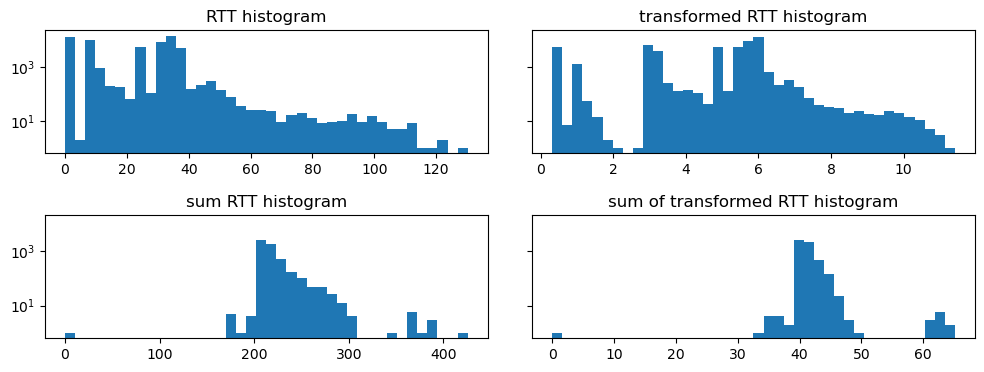

In [45]:
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2, 2, figsize=(12,4), sharey=True)
plt.title("RTT and log RTT distributions for CA-SFU-T2 to CSCS-LCG2")

ax1.hist(rtt, bins=40, log=True);
ax1.set_title("RTT histogram")

ax2.hist(log_rtt, bins=40, log=True);
ax2.set_title("transformed RTT histogram")

ax3.hist(sum_rtt, bins=40, log=True);
ax3.set_title("sum RTT histogram")
ax4.hist(sum_log_rtt, bins=40, log=True);
ax4.set_title("sum of transformed RTT histogram")
plt.subplots_adjust(hspace=0.5, wspace=0.1)

fig.savefig("results/figures/rtt_distributions.png", dpi=300, bbox_inches='tight')

In [6]:
from collections import defaultdict
from traced_v2.models.normal import NormalModel

In [86]:
rtt_models = defaultdict(lambda: {})
data_idx = defaultdict(lambda: [])
data_rtt = defaultdict(lambda: defaultdict(lambda: []))

rtt_model = NormalModel(src="CA-SFU-T2", dest="CSCS-LCG2", gamma=1, sigma_factor=4)
lengths = []
for i, trace in enumerate(data):
    total_rtt = np.sum((trace['rtts'] or [0]))
    # total_rtt = np.sum(np.diff(trace['rtts'] or [0]))
    # total_rtt = np.sum(np.log1p([x for x in trace['rtts'] if x]))
    if trace['dest'] not in rtt_models[trace['src']]:
        rtt_models[trace['src']][trace['dest']] = NormalModel(src=trace['src'], dest=trace['dest'],  gamma=1, sigma_factor=3)
    data_idx[trace['src']].append(i)
    for hop, rtt in zip(trace['hops'], trace['rtts']):
        data_rtt[trace['src']][hop].append(rtt)

    rtt_models[trace['src']][trace['dest']].log(trace['timestamp'], total_rtt)
    rtt_model.log(trace['timestamp'], total_rtt)
    # i -= 1
    # if i == 0:
    #     break

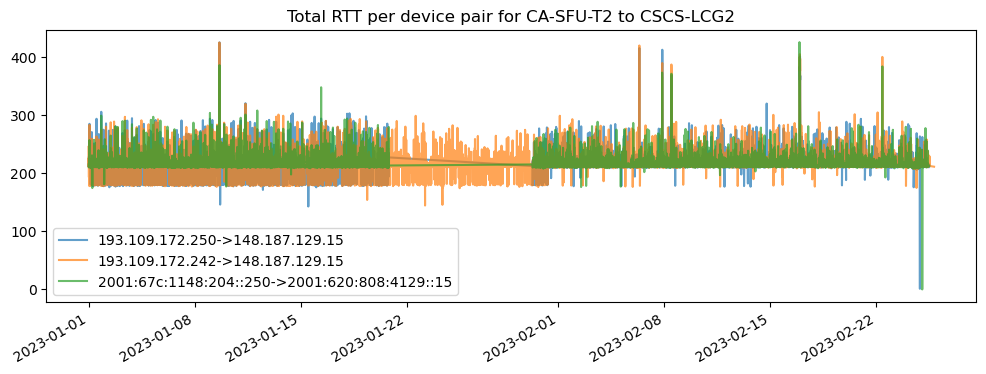

In [87]:
import  matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
for src in rtt_models:
    for dest in rtt_models[src]: 
        df = rtt_models[src][dest].to_frame()
        df.plot(y='observed_values', label=f'{src}->{dest}', ax=fig.gca(), alpha=0.7, linestyle='-',)

plt.title("Total RTT per device pair for CA-SFU-T2 to CSCS-LCG2")
fig.savefig("results/figures/rtt_device-to-device_log.png", dpi=300, bbox_inches='tight')

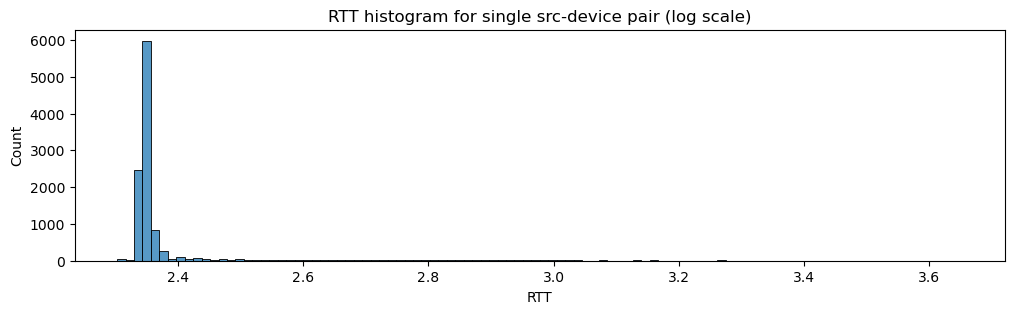

In [88]:
import seaborn as sns
fig = plt.figure(figsize=(12, 3))

sns.histplot(data=np.log1p(data_rtt['193.109.172.250']['130.206.214.97']), bins=100, log_scale=False, ax=fig.gca());
plt.title("RTT histogram for single src-device pair (log scale)")
# plt.ylabel("log of ount")
plt.xlabel("RTT")
fig.savefig("results/figures/rtt_single_device_pair.png", dpi=300, bbox_inches='tight')

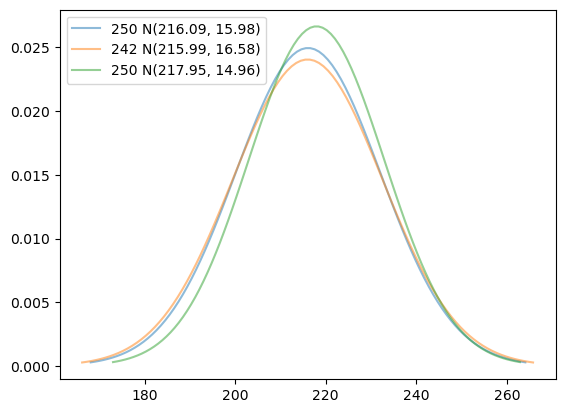

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# assuming rtt_models is a list of models
for src in rtt_models:
    for dest in rtt_models[src]:
        model = rtt_models[src][dest]
        mu, sigma = model.expected_values[-1], model.sigmas[-1]
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        pdf = norm.pdf(x, mu, sigma)
        plt.plot(x, pdf, alpha=0.5, label=f'{src.split(".")[-1].split(":")[-1]} N({mu:.2f}, {sigma:.2f})')
plt.legend()
plt.show()

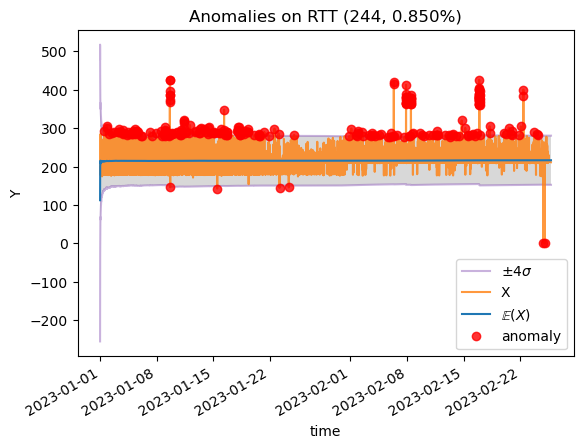

In [90]:
rtt_model.plot()

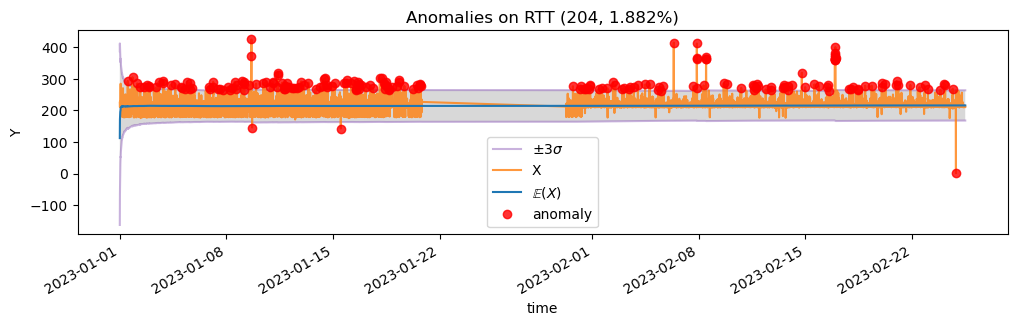

In [91]:
fig = plt.figure(figsize=(12, 3))
rtt_models['193.109.172.250']['148.187.129.15'].plot()

In [92]:
tmp = rtt_models['193.109.172.250']['148.187.129.15'].to_frame()
    

In [93]:
tmp['i'] = range(len(tmp))

In [94]:
file_idxs = tmp[tmp['anomalies']& (tmp['observed_values']>tmp['expected_values'])]['i'].apply(data_idx['193.109.172.250'].__getitem__)


In [109]:
rtts = []

for idx in file_idxs.values:
    rtts.append(np.sum(data[idx]['rtts']))

In [115]:
all_rtts = []
bl = set(file_idxs.values)
for i, file in enumerate(data):
    if i in bl:
        continue
    all_rtts.append(np.sum(file['rtts']))

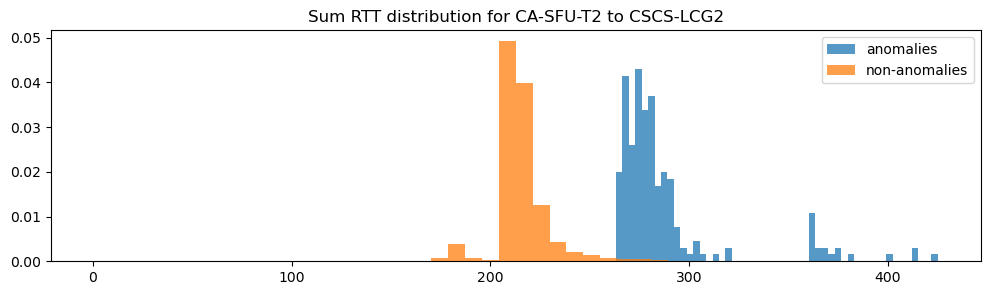

In [117]:
# plt.hist(rtts2, bins=50, density=True, alpha=0.5, label="Anomalies");
fig = plt.figure(figsize=(12, 3))
plt.hist(rtts, bins=50, density=True, alpha=0.75, label="anomalies");
plt.hist(all_rtts, bins=50, density=True, alpha=0.75, label="non-anomalies");
plt.legend()
plt.title("Sum RTT distribution for CA-SFU-T2 to CSCS-LCG2")
fig.savefig("results/figures/rtt_sum_distribution_comp.png", dpi=300, bbox_inches='tight')

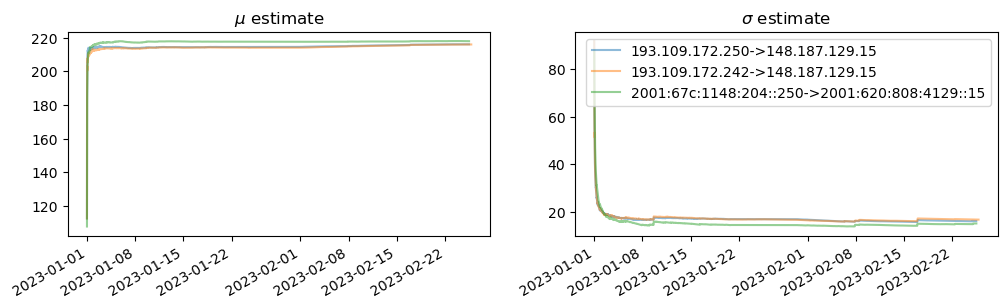

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# assuming rtt_models is a list of models
for src in rtt_models:
    for dest in rtt_models[src]:
        model_frame = rtt_models[src][dest].to_frame(omit_first=False).iloc[:]
        model_frame['expected_values'].plot(ax=ax1, alpha=0.5, label=f'{src}->{dest}')
        model_frame['sigmas'].plot(ax=ax2, alpha=0.5, label=f'{src}->{dest}')
        # ax1.plot(model_frame.index, model_frame['expected_values'], alpha=0.5, label=f'{src}->{dest}')
        # ax2.plot(model_frame.index, model_frame['sigmas'], alpha=0.5, label=f'{src}->{dest}')
ax1.set_title('$\mu$ estimate')
ax2.set_title('$\sigma$ estimate')
plt.legend()
fig.savefig("results/figures/rtt_device-to-device_mu_sigma_log.png", dpi=300, bbox_inches='tight')

In [24]:
tmp2 = model.to_frame()

In [25]:
tmp[tmp['anomalies'] & (tmp['observed_values'] < tmp['expected_values'] )]

,observed_values,expected_values,sigmas,anomalies,i
2023-01-09 16:28:27,146.0,214.244018,17.419030,True,2497
2023-01-15 12:08:29,142.7,214.332541,16.932928,True,4162
2023-02-24 21:06:13,1.1,216.080394,16.014741,True,10755


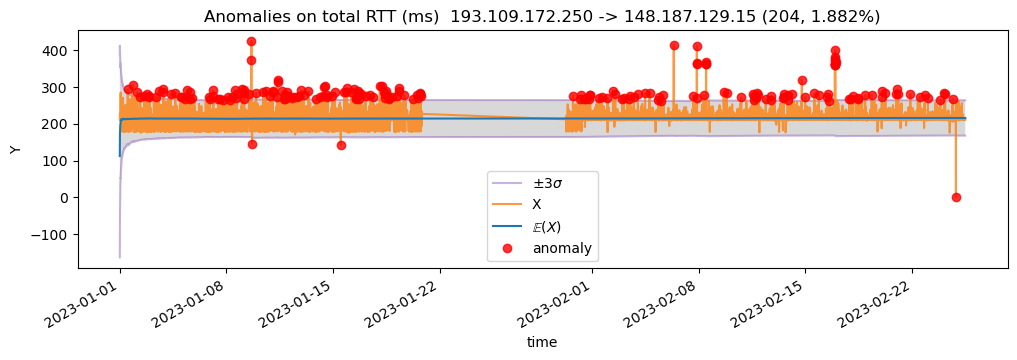

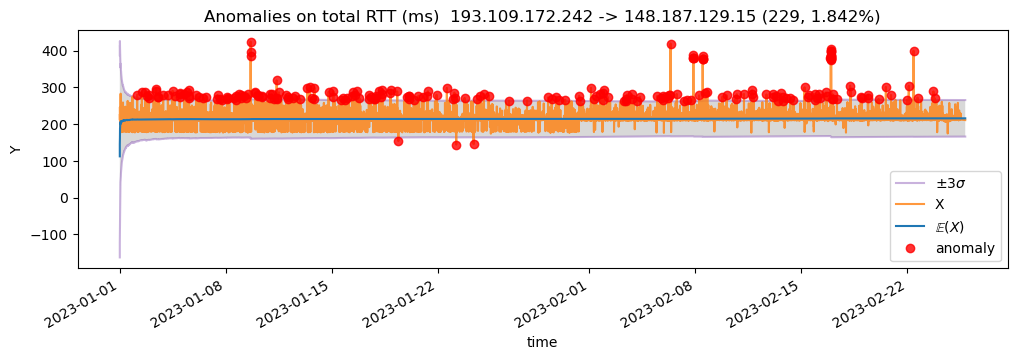

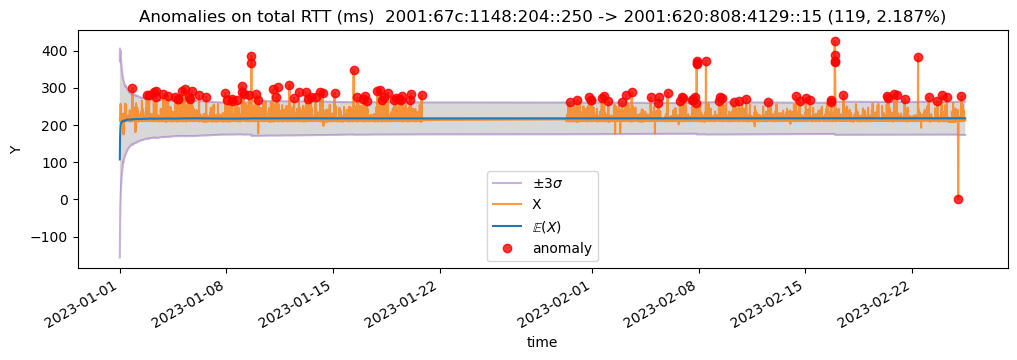

In [26]:
# fig, (ax) = plt.subplots(1, 1, figsize=(12, 8), sharex=True)
# ax_gen = (x for x in (ax, ax2, ax3))
for src in rtt_models:
    for dest in rtt_models[src]:
        fig = plt.figure(figsize=(12, 3.5))
        # ax = next(ax_gen)
        ax = fig.gca()
        rtt_models[src][dest].plot(ax=ax, kind=f"total RTT (ms)  {src} -> {dest}")
        ax.legend()
        fig.savefig(f"results/figures/rtt_{src}_{dest}_anoms_log.png", dpi=300, bbox_inches='tight')
        break
        # plt.title(f"Probability of observing IP sequences from {src} to {dest} ({len(ip_models[src][dest].seen_categories)} unique paths)")

## Trace

In [60]:
x = np.arange(0, 100, 5)
y = np.arange(0, 100, 5)
# z = hmean([x, y], axis=0)    

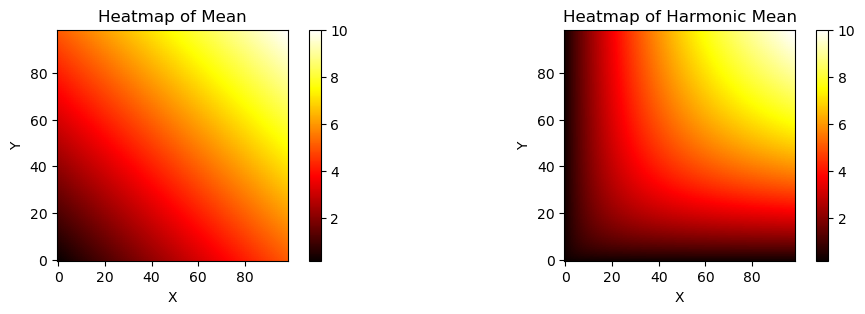

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def hmean(x, y):
    return 2 / (1/x + 1/y)

def mean(x, y):
    return (x+y)/2

# Example data
x = np.linspace(0.1, 10, 100)
y = np.linspace(0.1, 10, 100)

# Create meshgrid
X, Y = np.meshgrid(x[1:], y[1:])

# Compute harmonic mean values
hmean_values = np.vectorize(hmean)(X, Y)
mean_values = np.vectorize(mean)(X, Y)

# Create subplots
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(12, 3), sharey=False)

# Plot heatmap of harmonic mean
im1 = ax1.imshow(hmean_values, cmap='hot')
ax1.set_title('Heatmap of Harmonic Mean')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()  # Reverse the y-axis

# Plot heatmap of mean
im2 = ax2.imshow(mean_values, cmap='hot')
ax2.set_title('Heatmap of Mean')
fig.colorbar(im2, ax=ax2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.invert_yaxis()  # Reverse the y-axis

# Show the plot
plt.show()
fig.savefig("results/figures/harmonic_mean_mean_comp.png", dpi=300, bbox_inches='tight')

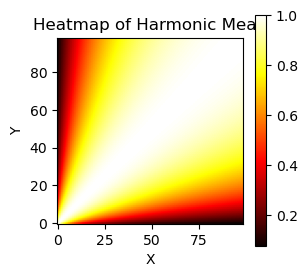

In [62]:
fig = plt.figure(figsize=(3, 3))
ax1=plt.gca()
im1 = ax1.imshow(hmean_values/mean_values, cmap='hot')
ax1.set_title('Heatmap of Harmonic Mean')
fig.colorbar(im1, ax=ax1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.invert_yaxis()  # Revers

In [4]:
from collections import defaultdict

In [5]:
from traced_v2.models.trace_model import TraceModel

In [6]:
tm = TraceModel(1,2, mode='mean')

In [67]:
trace_models = defaultdict(lambda: {})
for file in data:
    if file['dest'] not in trace_models[file['src']]:
        trace_models[file['src']][file['dest']] = TraceModel(file['src'], file['dest'], mode='mean')

    trace_models[file['src']][file['dest']].log(file['timestamp'], file['hops'], rtts=np.array(file['rtts']), ttls=(file['ttls']))

In [56]:
raise Exception("Stop here")

Exception: Stop here

In [68]:
import matplotlib.pyplot as plt

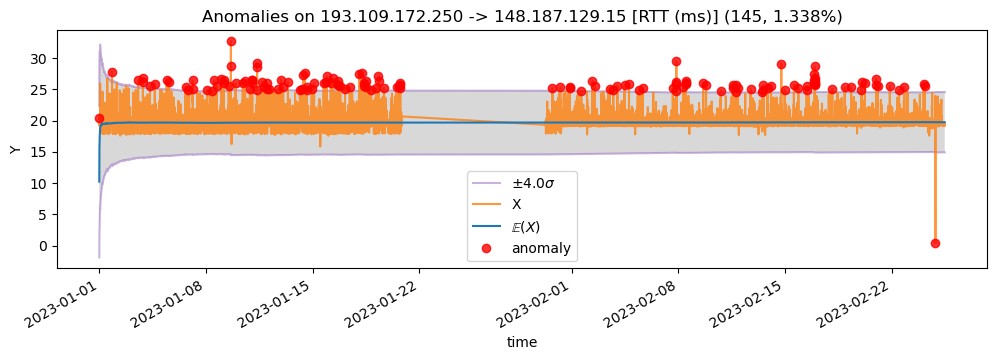

In [69]:
fig = plt.figure(figsize=(12, 3.5))
trace_models['193.109.172.250']['148.187.129.15'].final_rtt.plot(kind='193.109.172.250 -> 148.187.129.15 [RTT (ms)]')
fig.savefig("results/figures/rtt_193.109.172.250_148.187.129.15_hmean.png", dpi=300, bbox_inches='tight')

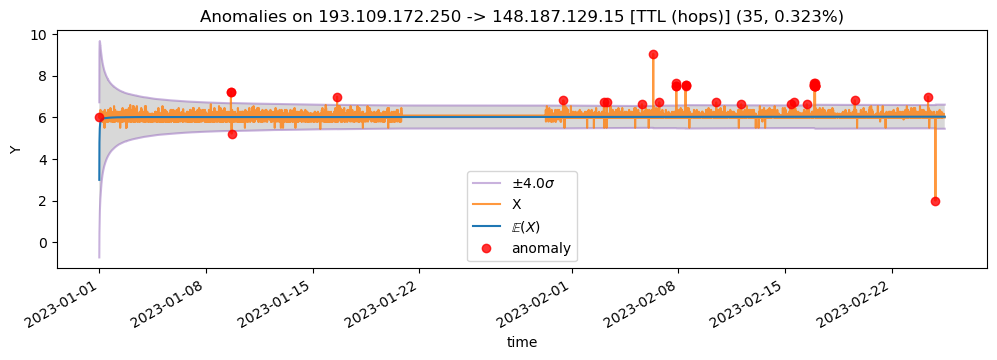

In [70]:
fig = plt.figure(figsize=(12, 3.5))
trace_models['193.109.172.250']['148.187.129.15'].final_ttl.plot(kind='193.109.172.250 -> 148.187.129.15 [TTL (hops)]')
fig.savefig("results/figures/ttl_193.109.172.250_148.187.129.15_hmean.png", dpi=300, bbox_inches='tight')

In [60]:
tmp = trace_models['193.109.172.250']['148.187.129.15'].to_frame()
tmp[['trace_rtt_anomalies', 'trace_ttl_anomalies']]

,trace_rtt_anomalies,trace_ttl_anomalies
2023-01-01 00:05:28,True,True
2023-01-01 00:07:55,False,False
2023-01-01 00:15:29,False,False
2023-01-01 00:18:59,False,False
2023-01-01 00:25:25,False,False
...,...,...
2023-02-25 10:58:24,False,False
2023-02-25 11:16:09,False,False
2023-02-25 11:35:43,False,False
2023-02-25 11:39:17,False,False


In [61]:
tmp['i'] = range((tmp.shape[0]))

In [62]:
data[7799]['rtts'], data[7799]['path_complete']

([0.0,
  0.0,
  1.0,
  9.4,
  9.6,
  23.099999999999998,
  30.200000000000003,
  32.7,
  35.6,
  34.8,
  34.4],
 True)

In [63]:
tmp[tmp['trace_rtt_anomalies']]['i'].sample(n=10)

2023-02-18 22:08:35     9774
2023-01-16 08:27:04     4402
2023-01-07 03:15:15     1763
2023-02-09 15:19:30     8030
2023-02-20 23:28:55    10115
2023-01-18 01:37:29     4891
2023-02-24 04:05:57    10643
2023-01-03 20:47:56      822
2023-02-21 02:16:13    10133
2023-02-09 19:48:36     8066
Name: i, dtype: int64

In [64]:
sums = []
for i in tmp[tmp['trace_rtt_anomalies']]['i'].values:
    sums.append(np.max((data[i]['rtts'])))


In [65]:
sample = []
for i in tmp['i'].sample(n=100).values:
    sample.append((np.max(data[i]['rtts'])))

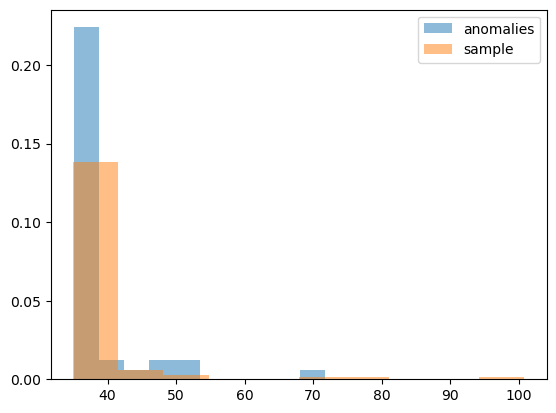

In [66]:
plt.hist(sums, alpha=0.5, density=True)
plt.hist(sample, alpha=0.5, density=True)
plt.legend(['anomalies', 'sample'])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(tmp['trace_rtt_anomalies'], tmp['trace_ttl_anomalies'])

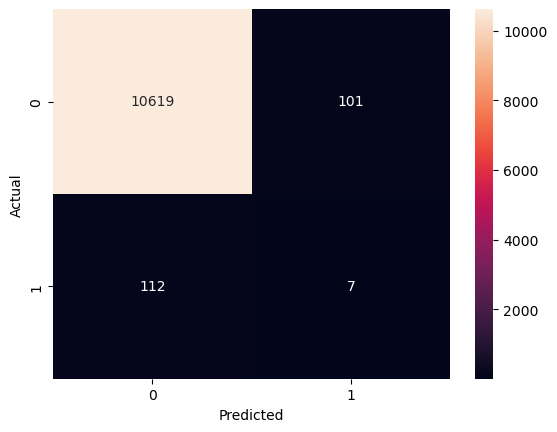

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [ ]:
tmp[tmp['trace_rtt_anomalies']&tmp['trace_ttl_anomalies']][['trace_rtt_observed_values', 'trace_rtt_expected_values','trace_ttl_observed_values', 'trace_ttl_expected_values']]

,trace_rtt_observed_values,trace_rtt_expected_values,trace_ttl_observed_values,trace_ttl_expected_values
2023-01-09 15:18:49,10.303610,0.019413,0.538607,-0.009896
2023-01-09 15:25:05,11.738277,0.024127,0.561525,-0.009666
2023-01-16 11:56:35,4.691046,-0.005996,0.409494,-0.010398
2023-01-16 15:49:42,5.151067,-0.005887,0.499156,-0.009965
2023-02-07 20:58:58,6.525926,-0.041084,0.796380,-0.007572
2023-02-16 22:15:19,4.495009,-0.025880,0.743789,-0.006191
2023-02-16 23:09:53,4.427207,-0.023958,0.754105,-0.005776


In [ ]:
tmp[tmp['trace_rtt_anomalies']&~tmp['trace_ttl_anomalies']][['trace_rtt_observed_values', 'trace_rtt_expected_values','trace_ttl_observed_values', 'trace_ttl_expected_values']]

,trace_rtt_observed_values,trace_rtt_expected_values,trace_ttl_observed_values,trace_ttl_expected_values
2023-01-01 20:07:57,7.212033,0.391759,0.226787,-0.005370
2023-01-03 13:16:44,5.821794,0.133459,-0.062306,-0.002428
2023-01-03 20:47:56,6.342825,0.118962,0.061933,-0.004654
2023-01-03 20:48:26,5.719204,0.125750,-0.060367,-0.004721
2023-01-04 07:57:09,5.098776,0.086712,-0.060767,-0.005022
...,...,...,...,...
2023-02-21 02:16:13,4.928109,-0.016889,-0.061222,-0.005370
2023-02-21 21:15:05,5.480700,-0.017321,-0.061183,-0.005422
2023-02-22 20:07:32,4.745295,-0.016000,-0.061290,-0.005337
2023-02-24 02:27:23,5.314991,-0.017190,-0.061582,-0.005153


In [ ]:
from scipy.stats import hmean

In [ ]:
nms = defaultdict(lambda: defaultdict(lambda: {}))

psn = defaultdict(lambda: defaultdict(lambda: {}))
errors = defaultdict(lambda: defaultdict(lambda: []))
weighted = defaultdict(lambda: defaultdict(lambda: []))

e_mean = []
e_seq = []
e_anom = []
masked_rtt=[]
masked_ttl=[]

for file in data:
    src = file['src']
    ts = file['timestamp']
    ttl_error = []
    rtt_error = []

    rtt_anomalies = []
    ttl_anomalies = []

    ttl_anoms_total = []
    rtt_anoms_total = []
    ns = []

    for hop, rtt, ttl in zip(file['hops'], file['rtts'], file['ttls']):
        if hop not in nms[src]:
            nms[src][hop] = NormalModel(src=src, dest=hop, gamma=1, sigma_factor=3, mu_0=rtt)
            psn[src][hop] = PoissonModel(src=src, dest=hop, threshold=0.1, )

        t = nms[src][hop].log(ts, rtt)
        h = psn[src][hop].log(ts, ttl)
        ttl_error.append(h.error)
        rtt_error.append(t.error)
        rtt_anomalies.append(t.is_anomaly)
        ttl_anomalies.append(h.is_anomaly)
        ttl_anoms_total.append(psn[src][hop].n_anomalies)
        rtt_anoms_total.append(nms[src][hop].n_anomalies)
        ns.append(nms[src][hop].n)

    rtt_seq_w, ttl_anom_seq_w = tm._calculate_anomaly_weights(
            rtt_anomalies, ttl_anomalies
        )
    uniform_w = np.ones_like(rtt_anomalies).astype(float)
    uniform_w /= uniform_w.sum()
    # rtt_seq_w, ttl_anom_seq_w = rtt_seq_w-1, ttl_anom_seq_w -1
    # rtt_n_anoms = np.log1p(rtt_anoms_total).astype(float)
    # rtt_n_anoms /= rtt_n_anoms.sum()
    # ttl_n_anoms = np.log1p(ttl_anoms_total).astype(float)
    # ttl_n_anoms /= ttl_n_anoms.sum()
    rtt_n_anoms =  1 - (np.array(rtt_anoms_total)+1)/(1+np.array(ns))
    rtt_n_anoms /= rtt_n_anoms.sum()
    ttl_n_anoms = 1 - (1+np.array(ttl_anoms_total))/(1+np.array(ns))
    ttl_n_anoms /= ttl_n_anoms.sum()

    masked_rtt.append(np.array(rtt_error)[np.where(rtt_anomalies)].mean() if any(rtt_anomalies) else 0)
    masked_ttl.append(np.array(ttl_error)[np.where(ttl_anomalies)].mean() if any(ttl_anomalies) else 0)

    e_mean.append(np.array(rtt_error) @ uniform_w.T)  
    e_seq.append(np.array(rtt_error) @ rtt_seq_w.T)  
    e_anom.append(np.array(rtt_error) @ rtt_n_anoms.T)  

    # final_w_rtt =  hmean([uniform_w, rtt_n_anoms, rtt_seq_w])
    # # final_w_rtt /= 3

    # final_w_ttl =  hmean([uniform_w, ttl_n_anoms, ttl_anom_seq_w])
    # # final_w_ttl /= 3

    # final_w_ttl = final_w_ttl
    # final_w_rtt = final_w_rtt

    # weighted[src][file['dest']].append(((file['ttls'], [x*y for x,y in zip(ttl_error, final_w_ttl)]), (file['rtts'], [x*y for x,y in zip(rtt_error, final_w_rtt)])))
    # errors[src][file['dest']].append(((file['ttls'], ttl_error),( file['rtts'], rtt_error)))

/var/folders/_s/_pzmy6qn25b08djfpy3jvf3w0000gn/T/ipykernel_37135/2910556695.py:52: RuntimeWarning:

divide by zero encountered in divide

/var/folders/_s/_pzmy6qn25b08djfpy3jvf3w0000gn/T/ipykernel_37135/2910556695.py:52: RuntimeWarning:

invalid value encountered in divide

/var/folders/_s/_pzmy6qn25b08djfpy3jvf3w0000gn/T/ipykernel_37135/2910556695.py:54: RuntimeWarning:

divide by zero encountered in divide

/var/folders/_s/_pzmy6qn25b08djfpy3jvf3w0000gn/T/ipykernel_37135/2910556695.py:54: RuntimeWarning:

invalid value encountered in divide



Text(0.5, 1.0, 'Boxplot with Sliding Window')

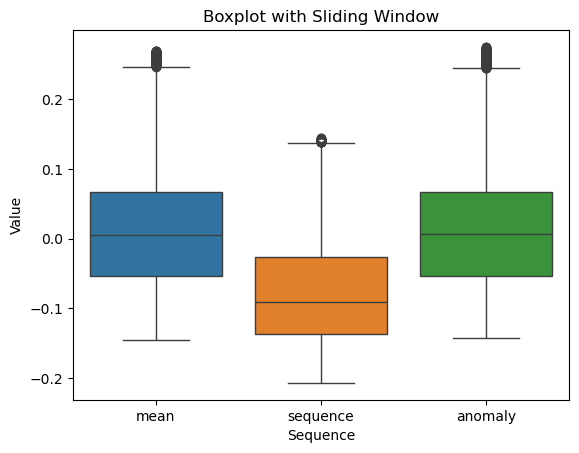

In [ ]:
# Set the window size for the rolling statistics
window_size = 1000

# Calculate the rolling statistics
tmp = pd.DataFrame({"mean": e_mean, "sequence": e_seq, "anomaly": e_anom})
rolling_data = tmp.rolling(window=window_size).mean()

# Plot the boxplot
sns.boxplot(data=rolling_data)
plt.xlabel('Sequence')
plt.ylabel('Value')
plt.title('Boxplot with Sliding Window')

# Show the change over time
# plt.xticks(range(len(rolling_data)), range(len(rolling_data)))
# plt.show()



<Axes: >

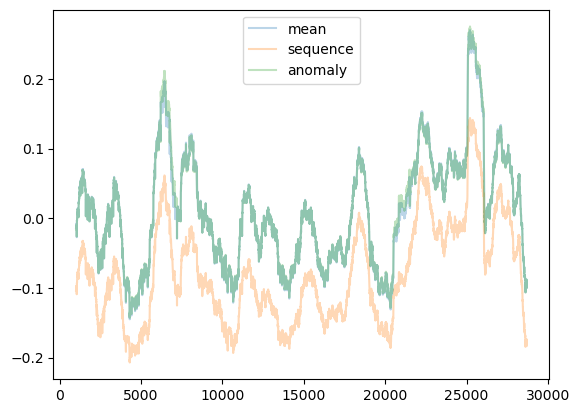

In [ ]:
rolling_data.plot(alpha=0.3)

In [ ]:
import random

def generate_unique_numbers(n):
    numbers = list(range(1, n+1))
    random.shuffle(numbers)
    return numbers

indexes = generate_unique_numbers(len(errors['193.109.172.250']['148.187.129.15']))


In [ ]:
# sample = []
# for i in indexes[:1000]:
#     sample.append(errors['193.109.172.250']['148.187.129.15'][i])
step = int(len( errors['193.109.172.250']['148.187.129.15'])/13)
sample = errors['193.109.172.250']['148.187.129.15'][:]
step
# for i in indexes[:1000]:
#     sample.append(errors['193.109.172.250']['148.187.129.15'][i])

833

In [ ]:
A, B = zip(*sample)


In [ ]:
ttls, ttl_errors = zip(*A)
rtts, rtt_errors = zip(*B)  

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle

def get_cyclic_colors(num_colors):
    """
    Returns a list of `num_colors` cyclic discrete colors for use in `matplotlib.pyplot`.
    """
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color_cycle = cycle(colors)
    return color_cycle

color_cycle = get_cyclic_colors(14)
 



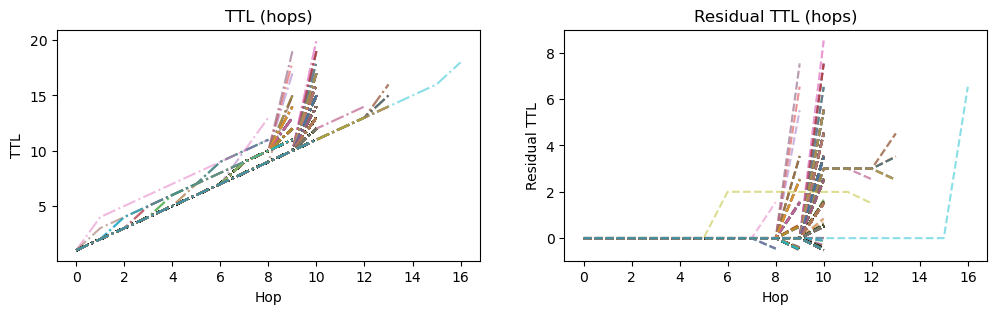

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 3))

for  ttl, ttl_error in A:
    X = np.arange(len(ttl))
    c = next(color_cycle)
    ax.plot(X, ttl, linestyle='-.', alpha=0.5, color=c)
    ax1.plot(X, ttl_error, linestyle='--', alpha=0.5, color=c)
ax.set_title("TTL (hops)")
ax1.set_title("Residual TTL (hops)")

ax.set_xlabel("Hop")
ax1.set_xlabel("Hop")
ax.set_ylabel("TTL")
ax1.set_ylabel("Residual TTL")

# fig.suptitle("TTL and Residual TTL sequences visualisation on last 300 samples", y=1.03)
fig.savefig("results/figures/standardization_of_ttl_.png", dpi=300, bbox_inches='tight')

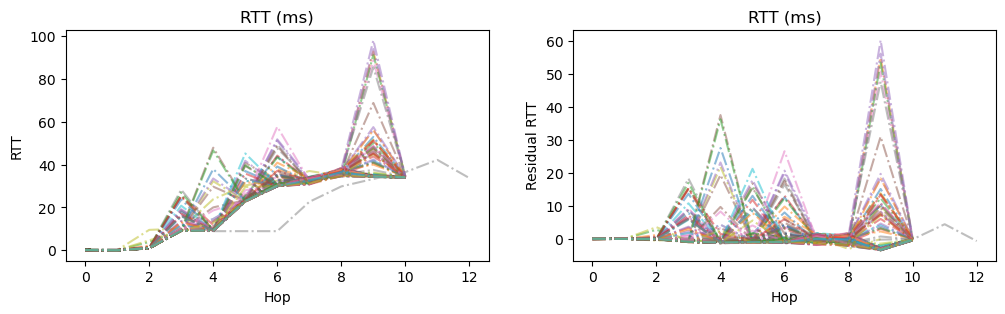

In [ ]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 3))
for  ttl, ttl_error in B:
    X = np.arange(len(ttl))
    ax.plot(X, ttl, linestyle='-.', alpha=0.5)
    ax1.plot(X, ttl_error, linestyle='-.', alpha=0.5)
ax.set_title("RTT (ms)")
ax1.set_title("RTT (ms)")

ax.set_xlabel("Hop")
ax1.set_xlabel("Hop")
ax.set_ylabel("RTT")
ax1.set_ylabel("Residual RTT")

# fig.suptitle("RTT and Residual RTT sequences visualisation on last 250 samples", y=1.03)
fig.savefig("results/figures/standardization_of_rtt_.png", dpi=300, bbox_inches='tight')

In [ ]:
me = []
mse = []
mae = []
median_error = []
rmse = []
mape = []
mad = []
rmsle = []
for  _, rtt_errors in B:
    rtt_errors = np.array(rtt_errors)
    me.append(np.mean(rtt_errors))
    mse.append(np.mean(rtt_errors**2))
    mae.append(np.mean(np.abs(rtt_errors)))
    median_error.append(np.median(rtt_errors))
    rmse.append(np.sqrt(np.mean(rtt_errors**2)))
    # mape.append(np.mean(np.abs(rtt_errors)/rtt_errors))
    # rmsle.append(np.sqrt(np.mean(np.log1p(rtt_errors)**2)))
    mad.append(np.median(np.abs(rtt_errors)))

In [ ]:
df = pd.DataFrame({
    'Mean Error' : me,
    'Mean Squared Error': mse,
    # 'mae': mae,
    # 'median_error': median_error,
    # 'rmse': rmse,
    # 'mape': mape, 
    'Root Mean Squared Error': rmse,
    # 'mad': mad
})

In [ ]:
# normalise the values
# df = (df - df.min())/(df.max()-df.min()) 

<Figure size 1200x300 with 0 Axes>

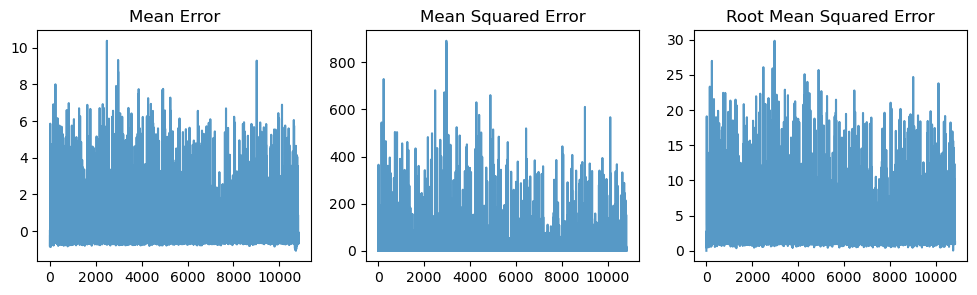

In [ ]:
fig = plt.figure(figsize=(12, 3))
# plot each column
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(df.columns), figsize=(12, 3))
# assuming df is your dataframe
for col, ax in zip(df.columns, axs):
    df[col].plot(kind='line', title=col, ax=ax, alpha=0.75)



In [ ]:
import importlib

In [ ]:
import importlib
import sys

def m_reload():
    for k,v in sys.modules.items():
        if k.startswith('traced_v2.model.trace_model'):
            importlib.reload(v)

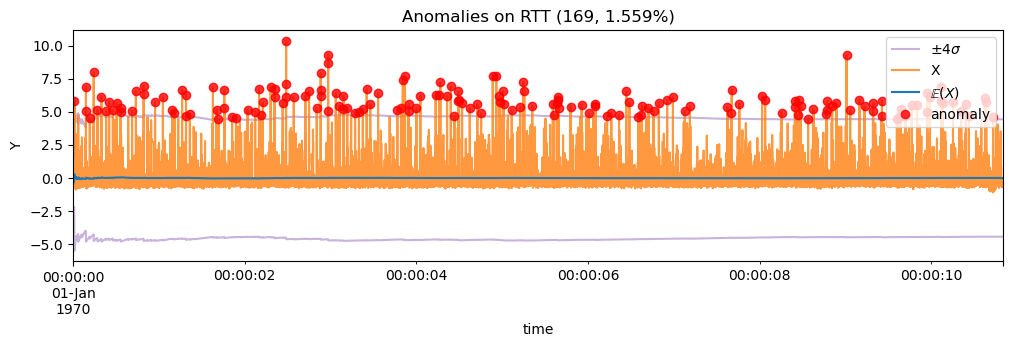

In [ ]:
fig = plt.figure(figsize=(12, 3))
tmp = NormalModel(1, 2, alpha_0=1, sigma_factor=4,)
for i, value in enumerate(df['Mean Error'].values):
    tmp.log(i, value*1)
tmp.plot()


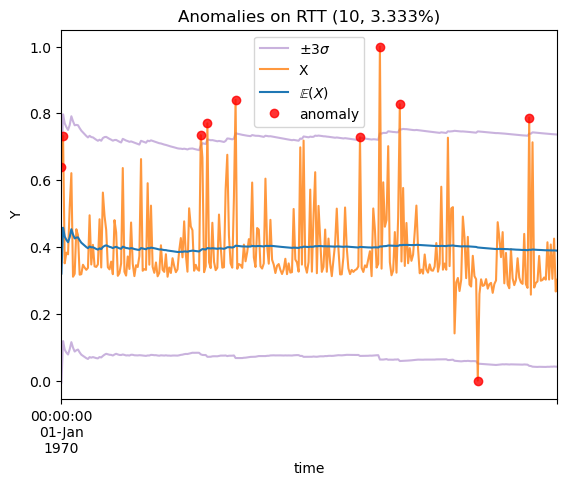

In [ ]:
tmp = NormalModel(1, 2, gamma=1, sigma_factor=3, mu_0=0, sigma_0=0.01, alpha_0 = 100, beta_0=1)
for i, value in  enumerate(df['rmsle'].values):
    tmp.log(i, value*1)
tmp.plot()


In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = plt.gca() 
seen = set()
sample =  np.random.choice(loaded_files, 6000)
for item in sample:
    if item.get('src_site', None) not in sites:
        continue
    try:
        if item['src_site'] not in seen:
            seen.add(item['src_site'])
            ax.plot(item['ttls'], item['rtts'], label=f"{item['src_site']} -> {item['dest_site']}", alpha=.5, c=colors[item['src_site']])
    
        else:
            ax.plot(item['ttls'], item['rtts'], label=None, alpha=.5, c=colors[item['src_site']])

    except KeyError:
        pass
    
ax.set_ylabel("RTT (ms)")
ax.set_xlabel("TTL (hops)")
plt.title("RTT and TTL for each traceroute ")
plt.legend()

fig.savefig("results/figures/rtt_vs_ttl.svg")

plt.show()

## Paths


In [ ]:
counter = defaultdict(lambda: defaultdict(lambda: 0))
values = defaultdict(lambda: defaultdict(lambda: []))
for  file in data:
    for ip, rtt in zip(file['hops'], file['rtts']):
        counter[file['src']][ip] += 1
        values[file['src']][ip].append(rtt)

In [ ]:
tokens = "I love Machine Learning".split()

In [ ]:
from hashlib import sha1

In [ ]:
from traced_v2.utils import create_hash, remove_duplicates


In [ ]:
from traced_v2.models.multinomial import MultinomialModel

In [ ]:
help(MultinomialModel.__init__)

Help on function __init__ in module traced_v2.models.multinomial:

__init__(self, src: str, dest: str, parent: traced_v2.models.base_model.BaseModel | None = None, gamma: float = 1.0) -> None
    Initialize self.  See help(type(self)) for accurate signature.



In [ ]:
ip_models = defaultdict(lambda: {})

In [ ]:
ip_models = defaultdict(lambda: {})
ip_model = MultinomialModel(src="CA-SFU-T2", dest="CSCS-LCG2")
lengths = []
i = 10
hashes = {}
field = 'asns'
for trace in data:
    lengths.append(len(trace[field]))
    hashed = create_hash('-'.join(map(str, trace[field])))
    hashes[hashed] = trace[field]
    if trace['dest'] not in ip_models[trace['src']]:
        ip_models[trace['src']][trace['dest']] = MultinomialModel(src=trace['src'], dest=trace['dest'])
        
    ip_models[trace['src']][trace['dest']].log(trace['timestamp'], hashed)
    ip_model.log(trace['timestamp'], hashed)
    # i -= 1
    # if i == 0:
    #     break

In [ ]:
def jaccard_similarity(a, b):
    len_a = len(a)
    len_b = len(b)
    a = set(a)
    b = set(b)
    if a.union(b) == set():
        return 0
    return len(a.intersection(b))/len(a.union(b)) * min(len_a, len_b)/max(len_a, len_b)

In [ ]:
similarities = defaultdict(lambda: defaultdict(lambda: 0))
for x in hashes:
    for y in hashes:
        similarities[x][y] = jaccard_similarity(hashes[x], hashes[y])


In [ ]:
tmp_df = pd.DataFrame(similarities)
sorted_index = sorted(tmp_df.index, key=lambda x: ip_model.category_probs[x], reverse=True)


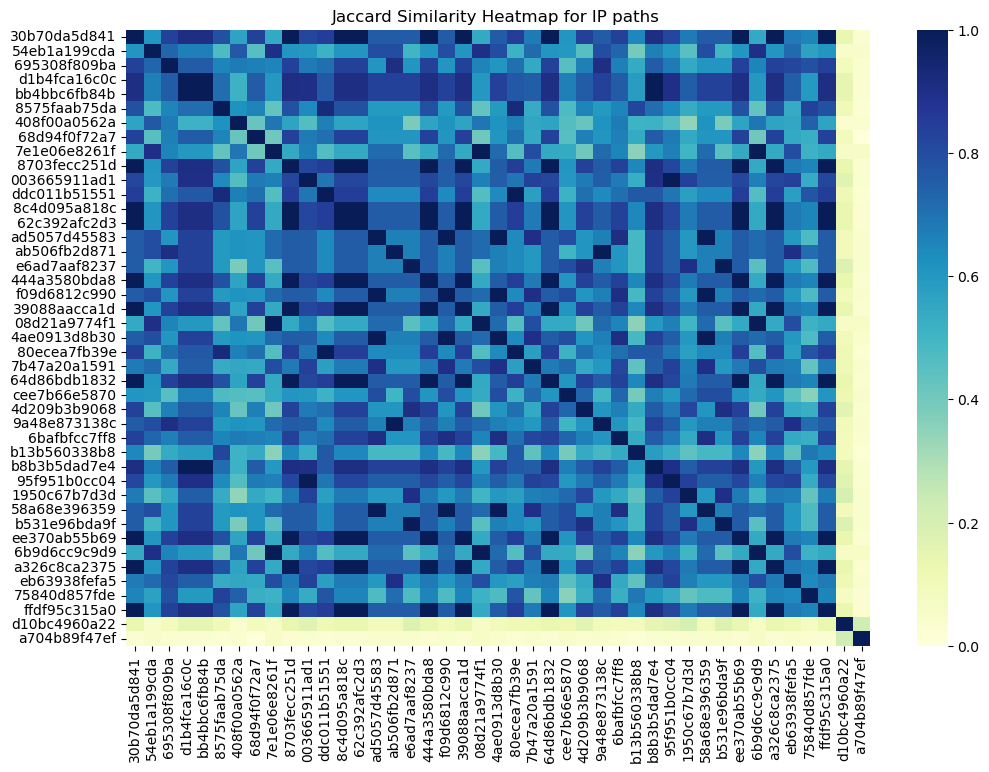

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
sns.heatmap(tmp_df.loc[sorted_index, sorted_index], cmap="YlGnBu")
plt.title("Jaccard Similarity Heatmap for IP paths ")
fig.savefig("results/figures/jaccard_similarity_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
max(ip_model.category_probs, key=ip_model.category_probs.get)

'4996a5f16182'

In [ ]:
# 30b70da5d841
# 30b70da5d841
# 54eb1a199cda
hashes['4996a5f16182']

['193.109.172.254',
 '192.168.50.58',
 '84.88.16.105',
 '130.206.214.97',
 '62.40.125.134',
 '62.40.98.227',
 '62.40.98.236',
 '62.40.124.22',
 '130.59.38.70',
 '148.187.0.2',
 '148.187.129.15']

In [ ]:
# 4996a5f16182
# 536c12e6ad48
# ca38beb13228
hashes['ca38beb13228']

['2001:67c:1148:204::254',
 '2001:67c:1148:177::2',
 '2001:720:400::1000:41',
 '2001:798:99:1::61',
 '2001:798:cc:1::96',
 '2001:798:cc:1::a9',
 '2001:798:12:10aa::2',
 '2001:620:0:c05c::2',
 '2001:620:0:ffaf::',
 '2001:620:808:4129::15']

Text(0.5, 1.0, 'Probability of observing IP sequences from CA-SFU-T2 to CSCS-LCG2 (56 unique paths)')

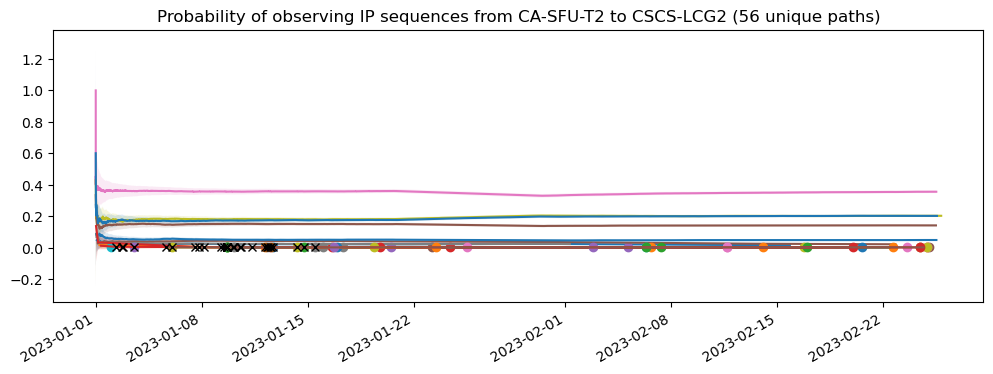

In [ ]:
fig = plt.figure(figsize=(12, 4))
# ip_model.kl_divergence_model.anomalies = [False] * (ip_model.kl_divergence_model.n+1)
ip_model.plot(ax=fig.gca())
# plt.legend( )
plt.title(f"Probability of observing IP sequences from CA-SFU-T2 to CSCS-LCG2 ({len(ip_model.seen_categories)} unique paths)")

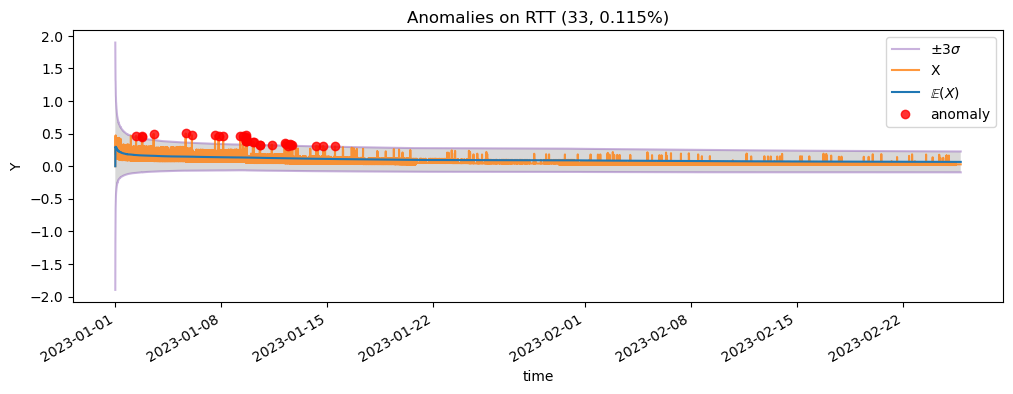

In [ ]:
fig = plt.figure(figsize=(12, 4))
ip_model.kl_divergence_model.plot(ax=fig.gca(), anom_label="")

In [ ]:
from scipy.stats import multinomial

In [ ]:
from scipy.stats import multinomial

4996a5f16182
536c12e6ad48
ca38beb13228


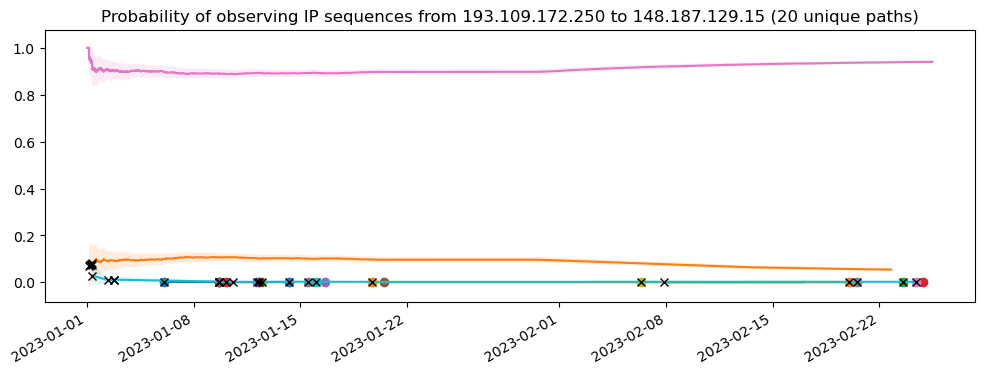

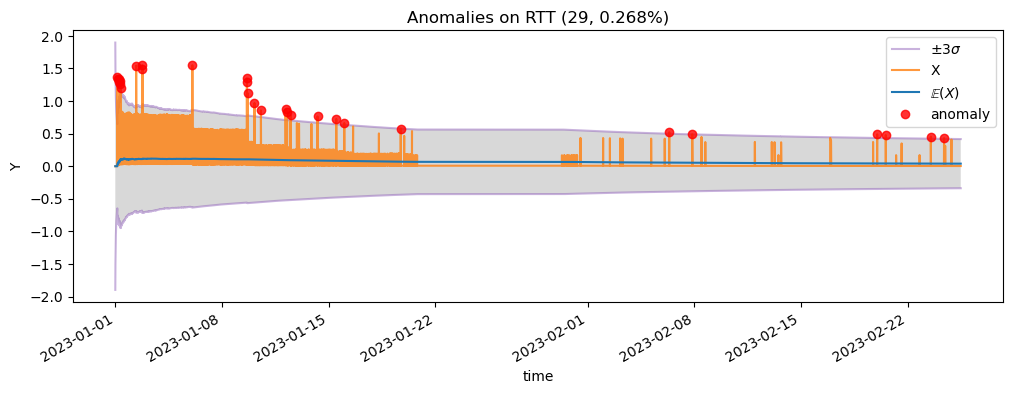

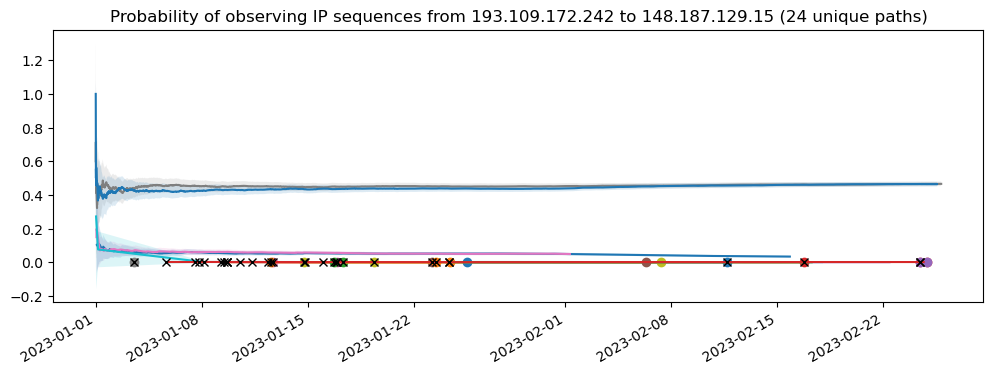

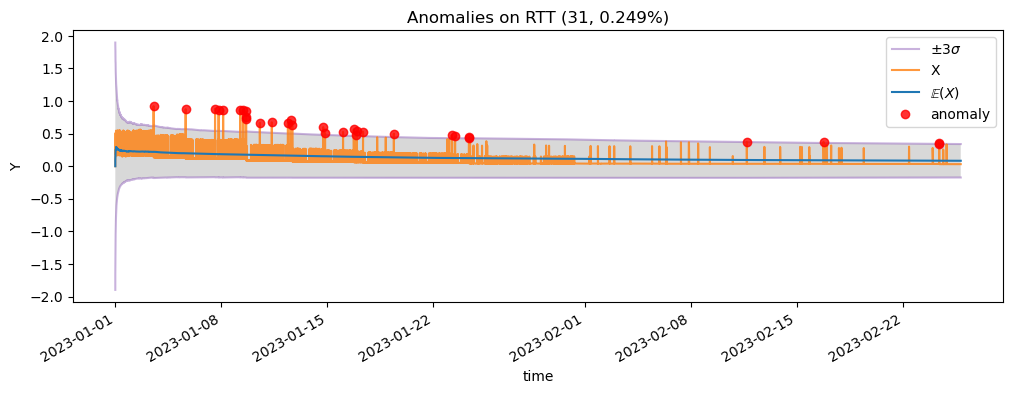

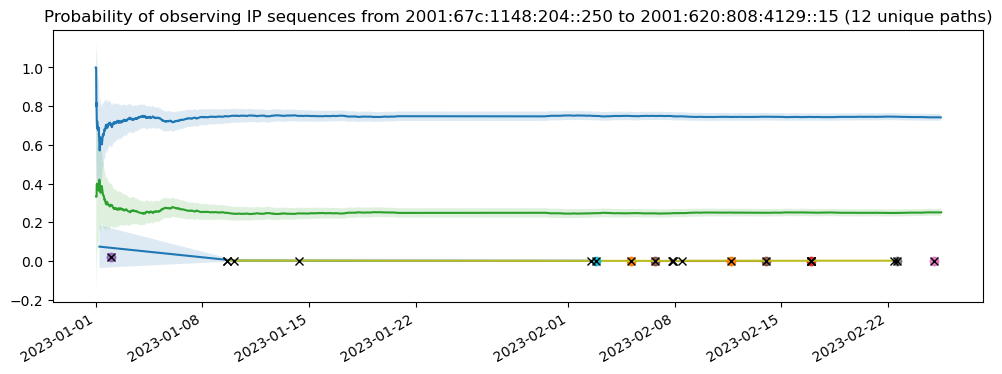

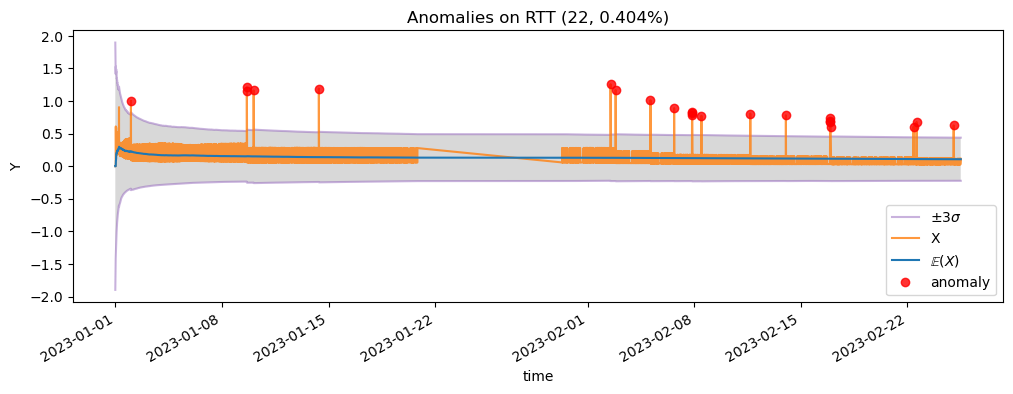

In [ ]:
for src in ip_models:
    for dest in ip_models[src]:
        fig = plt.figure(figsize=(12, 4))
        ip_models[src][dest].plot()
        plt.title(f"Probability of observing IP sequences from {src} to {dest} ({len(ip_models[src][dest].seen_categories)} unique paths)")
        fig = plt.figure(figsize=(12, 4))
        ip_models[src][dest].kl_divergence_model.plot(ax=fig.gca(), anom_label="")
        print(max( ip_models[src][dest].category_probs, key= ip_models[src][dest].category_probs.get))